In [15]:
import sys
sys.path.append("../")

In [16]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

In [17]:
from MultilabelKernelPerceptron import MultilabelKernelPerceptron
from KMeans import DATASET_LOCATION, DEVICE
from MNIST import mnist_loader, label_set
from utils import polynomial, sgn_label, sgn, SEED

import os
import shutil

_ = torch.manual_seed(SEED)

DIGITS_DIR = "digits"

## Load the data

In [18]:
training_batch_size = 60_000
test_batch_size = 10_000

(x_train, y_train), (x_test, y_test) = mnist_loader(training_batch_size, test_batch_size)

## Sample

In [19]:
num = 30
rows = 5
cols = 6

examples = x_test[:num]
labels = y_test[:num]

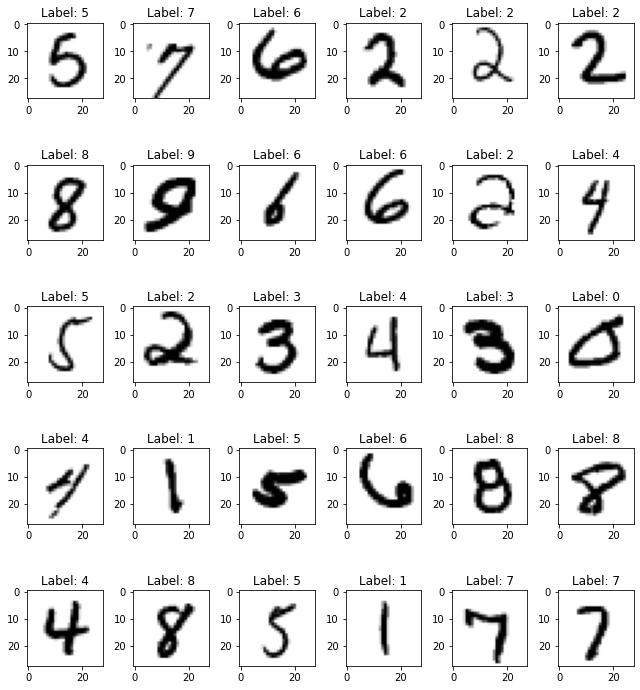

In [20]:
fig, axes = plt.subplots(rows, cols, figsize=(1.5 * cols, 2 * rows))

for i in range(num):
    ax = axes[i // cols, i % cols]
    image = examples[i].reshape((1, 28, 28))
    ax.imshow(image[0], cmap='gray_r')
    ax.set_title(f"Label: {labels[i]}")
    
plt.tight_layout()
plt.show()

## Run the algorithm with the 1500 reduction

In [21]:
x_train_km = torch.load(f"../{DATASET_LOCATION}/1500/x_train_km.pt")
y_train_km = torch.load(f"../{DATASET_LOCATION}/1500/y_train_km.pt")

epochs, degree = 5, 5
mkp = MultilabelKernelPerceptron(partial(polynomial, degree=degree), label_set, epochs, x_train_km, y_train_km, "mean", DEVICE)

In [22]:
%%time
mkp.fit()

CPU times: user 4.22 s, sys: 4.27 ms, total: 4.23 s
Wall time: 4.05 s


In [23]:
def classify(model, examples):
    kernel_matrix = polynomial(examples, x_train_km.T)
    scores = torch.zeros((model.shape[0], examples.shape[0]))

    for label, alpha in enumerate(model):
        scores[label] = torch.sum(kernel_matrix * sgn_label(y_train_km, label) * alpha, 1)

    return torch.argmax(scores, 0)

Error on the isolated examples: 16%


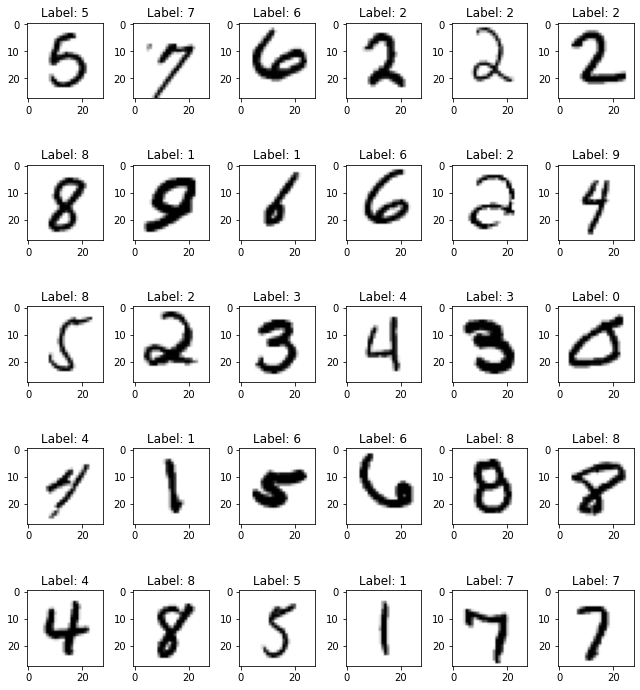

In [24]:
fig, axes = plt.subplots(rows, cols, figsize=(1.5 * cols, 2 * rows))

predictions = classify(mkp.model, examples)
print(f"Error on the isolated examples: {int(mkp.error(examples, labels) * 100)}%")

for i in range(num):    
    ax = axes[i // cols, i % cols]
    image = examples[i].reshape((1, 28, 28))
    ax.imshow(image[0], cmap='gray_r')
    ax.set_title(f"Label: {predictions[i]}")
    
plt.tight_layout()
plt.show()

### K-means digits
To speed up computations the dataset has been reduced using k-means, we can visualize the obtained digits.

Error on the isolated examples (cluterized): 0%


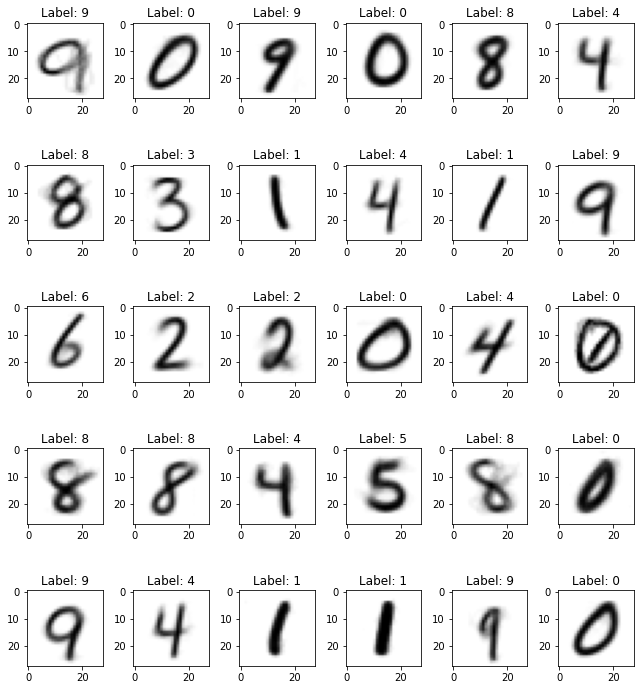

In [25]:
fig, axes = plt.subplots(rows, cols, figsize=(1.5 * cols, 2 * rows))

examples_km = x_train_km[:num]
labels_km = y_train_km[:num]

predictions = classify(mkp.model, examples_km)
print(f"Error on the isolated examples (cluterized): {int(mkp.error(examples_km, labels_km) * 100)}%")

for i in range(num):    
    ax = axes[i // cols, i % cols]
    image = examples_km[i].reshape((1, 28, 28))
    ax.imshow(image[0], cmap='gray_r')
    ax.set_title(f"Label: {int(predictions[i])}")
    
plt.tight_layout()
plt.show()

### Save clusterized digits

In [30]:
if os.path.exists(DIGITS_DIR):
    shutil.rmtree(DIGITS_DIR)

os.mkdir(DIGITS_DIR)

for label in range(10):
    indexes = (y_train_km == label).nonzero()
    os.mkdir(f"{DIGITS_DIR}/{label}")
    
    for index, counter in zip(indexes, range(16)):
        image = x_train_km[index].reshape((1, 28, 28))
        plt.imsave(f"{DIGITS_DIR}/{label}/{label}-{counter+1}.png", image[0], cmap='gray_r')